# Part 2: Text-to-Image Search (Flickr8k + CLIP)

**Goal**
- Load precomputed image embeddings and metadata from Part 1
- Encode a text query with CLIP
- Compute cosine similarity between the query and all image embeddings
- Display the top-5 most similar images and a brief analysis

**Inputs**: `../embeddings/image_embeddings.npy`, `../embeddings/metadata.csv`  
**Images**: `../data/flickr8k/Images/`


In [1]:
# Imports & Config

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from transformers import CLIPProcessor, CLIPModel

import re
from typing import List, Dict


# Paths (works when running this notebook from notebooks/)
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]
EMB_DIR = PROJECT_ROOT / "embeddings"
DATA_DIR = PROJECT_ROOT / "data" / "flickr8k"
IMAGES_DIR = DATA_DIR / "Images"

IMAGE_EMB_FILE = EMB_DIR / "image_embeddings.npy"
META_FILE = EMB_DIR / "metadata.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cpu'

In [2]:
# Load Embeddings & Metadata (with checks)

assert IMAGE_EMB_FILE.exists(), f"Missing {IMAGE_EMB_FILE} — run Part 1 first."
assert META_FILE.exists(), f"Missing {META_FILE} — run Part 1 first."
assert IMAGES_DIR.exists(), f"Missing images dir: {IMAGES_DIR}"

image_embs = np.load(IMAGE_EMB_FILE)                # shape [N, D], L2-normalized in Part 1
meta_df = pd.read_csv(META_FILE)                    # columns: ['image','caption']

assert len(meta_df) == image_embs.shape[0], "Mismatch between rows in metadata and embeddings."
print("Embeddings shape:", image_embs.shape)
meta_df.head()


Embeddings shape: (8091, 512)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [3]:
# Load CLIP (same model as Part 1)

MODEL_NAME = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME)

# quick sanity: embedding dimension must match
with torch.no_grad():
    dummy = clip_processor(text=["test"], return_tensors="pt").to(DEVICE)
    dim = clip_model.get_text_features(**dummy).shape[-1]
print("Text embedding dim:", dim)
assert image_embs.shape[1] == dim, "Embed dimension mismatch — ensure same CLIP model as in Part 1."


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Text embedding dim: 512


In [5]:
# Encode text + Search utilities

@torch.no_grad()
def embed_text(prompts: List[str], model: CLIPModel, processor: CLIPProcessor, device: str = "cpu") -> np.ndarray:
    """Return L2-normalized text embeddings, shape [B, D]."""
    inputs = processor(text=prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    feats = model.get_text_features(**inputs)
    feats = feats / feats.norm(p=2, dim=-1, keepdim=True)
    return feats.detach().cpu().numpy()

def cosine_topk(text_emb: np.ndarray, image_embs: np.ndarray, k: int = 5) -> np.ndarray:
    """
    Since both are L2-normalized, cosine = dot product.
    text_emb: [1, D], image_embs: [N, D]
    Returns indices of top-k images.
    """
    scores = image_embs @ text_emb[0]          # [N]
    top_idx = np.argpartition(scores, -k)[-k:]
    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]
    return top_idx, scores

def get_results_df(top_idx: np.ndarray, scores: np.ndarray, meta: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for i in top_idx:
        rows.append({
            "image": meta.loc[i, "image"],
            "caption": meta.loc[i, "caption"],
            "cosine": float(scores[i])
        })
    return pd.DataFrame(rows)


In [6]:
# Visualization helpers (grid + bar chart)

def show_top_images_grid(image_names: List[str], images_dir: Path, cols: int = 5, size=(3,3)):
    """Display images in a single-row grid."""
    n = len(image_names)
    cols = min(cols, n)
    fig, axes = plt.subplots(1, cols, figsize=(cols*size[0], size[1]))
    if cols == 1:
        axes = [axes]
    for ax, name in zip(axes, image_names):
        path = images_dir / name
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(name, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_topk_scores(df: pd.DataFrame):
    """Simple bar chart for cosine scores."""
    plt.figure(figsize=(6,3))
    plt.bar(range(len(df)), df["cosine"].values)
    plt.xticks(range(len(df)), [Path(n).name for n in df["image"].values], rotation=45, ha="right", fontsize=8)
    plt.ylabel("Cosine similarity")
    plt.title("Top-k similarity scores")
    plt.tight_layout()
    plt.show()


In [7]:
# Lightweight explanation (brief analysis)

STOPWORDS = set("""
a an the and or of to is are in on at for from with by as into onto about over under after before while during
this that these those there here it its their his her him she he they we you your our
""".split())

def tokenize(text: str) -> List[str]:
    toks = re.findall(r"[a-z]+", text.lower())
    return [t for t in toks if t not in STOPWORDS and len(t) > 2]

def brief_analysis(query: str, result_df: pd.DataFrame) -> str:
    """
    Heuristic explanation:
    - Token overlap between query and captions
    - Mentions the most common shared keywords across top results
    """
    q_tokens = set(tokenize(query))
    overlaps: List[Dict] = []
    shared_counter = {}

    for _, row in result_df.iterrows():
        cap_tokens = set(tokenize(str(row["caption"])))
        inter = q_tokens & cap_tokens
        for t in inter:
            shared_counter[t] = shared_counter.get(t, 0) + 1
        overlaps.append({
            "image": row["image"],
            "overlap": sorted(list(inter)),
            "score": row["cosine"],
        })

    if shared_counter:
        top_shared = sorted(shared_counter.items(), key=lambda x: (-x[1], x[0]))[:5]
        shared_text = ", ".join([f"{w} (×{c})" for w, c in top_shared])
    else:
        shared_text = "No obvious keyword overlaps (CLIP may rely on visual-semantic cues beyond exact words)."

    lines = [
        f"Query keywords: {', '.join(sorted(q_tokens)) or '—'}",
        f"Common overlaps across top results: {shared_text}",
        "",
        "Per-image overlaps:"
    ]
    for item in overlaps:
        name = Path(item['image']).name
        ov = ", ".join(item["overlap"]) if item["overlap"] else "—"
        lines.append(f"- {name}: {ov} (cosine={item['score']:.3f})")

    lines.append("\nOverall: The model likely focused on high-level concepts present in the query (objects, scenes, actions).")
    return "\n".join(lines)


In [8]:
# Define a query and run search

# Example query:
QUERY = "a brown dog running on the beach"

# 1) Encode text
text_emb = embed_text([QUERY], clip_model, clip_processor, device=DEVICE)

# 2) Find top-5 images
TOPK = 5
top_idx, scores = cosine_topk(text_emb, image_embs, k=TOPK)
results_df = get_results_df(top_idx, scores, meta_df)

# 3) Sort results by score desc for display
results_df = results_df.sort_values("cosine", ascending=False).reset_index(drop=True)

QUERY, results_df


('a brown dog running on the beach',
                        image  \
 0  2089442007_6fc798548c.jpg   
 1   488416045_1c6d903fe0.jpg   
 2  3235746553_a40416c00e.jpg   
 3   489372715_ce52da796a.jpg   
 4   467960888_6943257534.jpg   
 
                                              caption    cosine  
 0              A brown dog is walking in the water .  0.368728  
 1             A brown dog is running along a beach .  0.355478  
 2  A brown dog begins to run along a beach with a...  0.354374  
 3  A brown dog is shaking his head while standing...  0.351511  
 4  A black dog running along the edge of the ocean .  0.350715  )

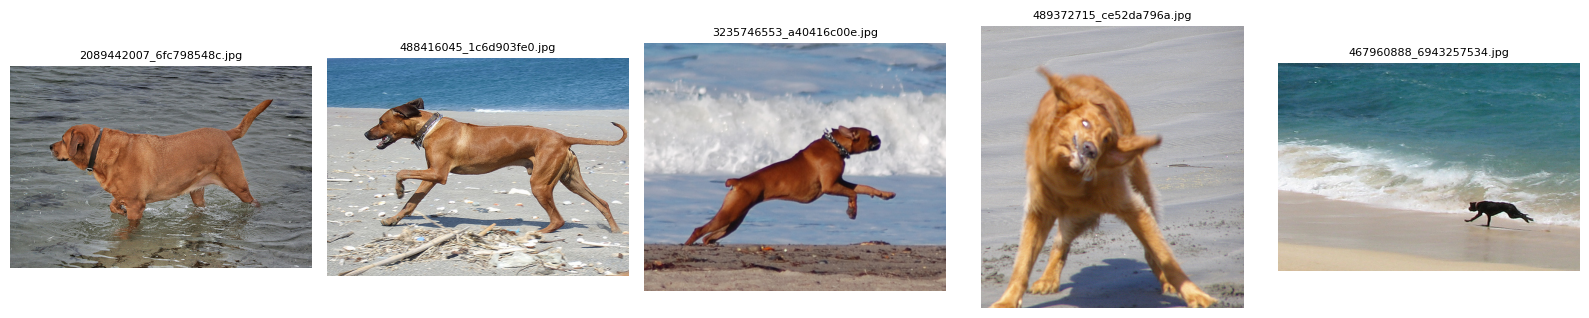

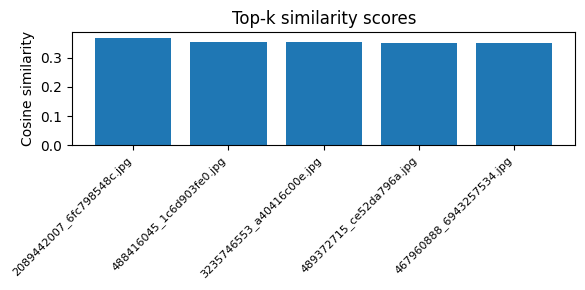

In [9]:
# Show images (grid) + scores (bar chart)

# Image grid (Top-5)
show_top_images_grid(results_df["image"].tolist(), IMAGES_DIR, cols=5, size=(3.2,3.2))

# Score chart
plot_topk_scores(results_df)


In [10]:
# Brief analysis (Markdown output)

print("Query:", QUERY)
print("\nBrief analysis:\n")
print(brief_analysis(QUERY, results_df))

Query: a brown dog running on the beach

Brief analysis:

Query keywords: beach, brown, dog, running
Common overlaps across top results: dog (×5), brown (×4), beach (×2), running (×2)

Per-image overlaps:
- 2089442007_6fc798548c.jpg: brown, dog (cosine=0.369)
- 488416045_1c6d903fe0.jpg: beach, brown, dog, running (cosine=0.355)
- 3235746553_a40416c00e.jpg: beach, brown, dog (cosine=0.354)
- 489372715_ce52da796a.jpg: brown, dog (cosine=0.352)
- 467960888_6943257534.jpg: dog, running (cosine=0.351)

Overall: The model likely focused on high-level concepts present in the query (objects, scenes, actions).


### What this notebook produced

- A working **text-to-image** search using CLIP.
- For each query, the notebook:
  - Encoded text with CLIP,
  - Computed cosine similarity against all image embeddings,
  - Displayed the **Top-5** images,
  - Plotted similarity scores,
  - Printed a brief, keyword-based analysis.

These components will be reused in **Part 3** for a Streamlit UI (text input → image results).
